# Урок 8. Generative Adversarial Networks

Обучить генератор создавать точки, которые будут лежать на графике функции 𝑦=sin(𝑥)𝑥−𝑥10

При выполнении данного задания структура GAN остается той же, но Вам нужно:

- Сгенерировать настоящие данные
- Изменить архитектуру дискриминатора и генератора
- Построить графики

In [1]:
import numpy as np
import pandas as pd
import random
from sklearn.preprocessing import MinMaxScaler

import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

import torch
import torch.nn as nn
from torch.utils.data import DataLoader

def func(x):
    """Возвращает значение функции y = (sin(x)/x) - (x/10)"""
    return (np.sin(x)/x) - (x/10)

class MyOwnClass(torch.utils.data.Dataset):
   
    def __init__(self, data):
        self._data = data

    def __len__(self):
        return len(self._data)

    def __getitem__(self, idx):
        point = self._data[idx] 
       
        return point

class Generator(nn.Module):
    def __init__(self):
        super().__init__()
        
        self.activations = nn.ModuleDict([
            ['lrelu', nn.LeakyReLU(0.2, inplace=True)],
            ['relu', nn.ReLU()]
        ])
        
        def block(in_feat, out_feat, normalize=True, activation='relu'):
            layers = [nn.Linear(in_feat, out_feat)]
            if normalize:
                layers.append(nn.BatchNorm1d(out_feat))
            layers.append(self.activations[activation])
            return layers

        self.model = nn.Sequential(
            *block(latent_dim, 128, normalize=False),
            *block(128, 256, activation='lrelu'),
            *block(256, 512),
            *block(512, 1024),
             nn.Linear(1024, 2),
             nn.Linear(2, 2),
             nn.Tanh()
        )
        
    def forward(self, z):
        new_point = self.model(z)
        new_point = new_point.reshape(-1, 2)
        return new_point 

class CustomLinearLayer(nn.Module):
    def __init__(self, size_in, size_out):
        super().__init__()
        self.size_in, self.size_out = size_in, size_out
        
        weights = torch.Tensor(size_out, size_in)
        self.weights = nn.Parameter(weights)

        bias = torch.Tensor(size_out)
        self.bias = nn.Parameter(bias)

        nn.init.uniform_(self.weights, -0.005, 0.005) 
        nn.init.uniform_(self.bias, -0.005, 0.005)  

    def forward(self, x):
        w_times_x = torch.mm(x, self.weights.t())
        return torch.add(w_times_x, self.bias)  

class Discriminator(nn.Module):
    def __init__(self):
        super().__init__()

        self.model = nn.Sequential(
            CustomLinearLayer(2, 512),
            nn.LeakyReLU(0.2, inplace=True),
            CustomLinearLayer(512, 256),
            nn.LeakyReLU(0.2, inplace=True),
            CustomLinearLayer(256, 1),
            nn.Sigmoid()
        )
        
    def forward(self, img):
        img_flat = img
        validity = self.model(img_flat)
        return validity

def plot_points(model, real):
    x1, y1 = (real.detach()).T
    x2, y2 = (model.detach()).T
    plt.scatter(x1, y1, color='green', label='Точки графика') 
    plt.scatter(x2, y2, color='red', label='Предсказано моделью') 
    plt.legend()
    plt.show()


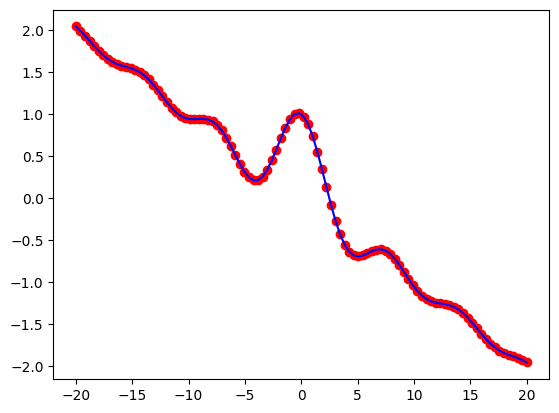

In [2]:
# визуализация графика функции
x = np.linspace(-20, 20, 100)
plt.scatter(x, y=func(x), color='red')
plt.plot(x, func(x), color='blue')
plt.show()

In [3]:
x = np.linspace(-20, 20, 200000)
df_train = pd.DataFrame({'x': x, 'y': func(x)})

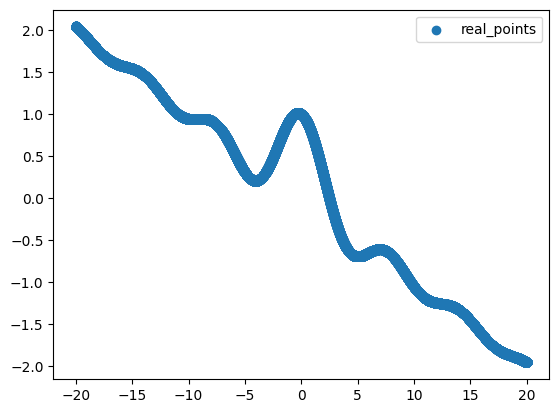

In [4]:
x,y = df_train.values.T
plt.scatter(x,y,label='real_points')
plt.legend()
plt.show()

In [5]:
# нормализация данных для обучения
scaler = MinMaxScaler()
data_train = scaler.fit_transform(df_train)  
data_train = torch.FloatTensor(data_train).float()

In [6]:
# датасет и даталоадер
train_dataset = MyOwnClass(data_train)

train_loader = torch.utils.data.DataLoader(train_dataset,
                          batch_size=128,
                          shuffle=True,
                          drop_last=True,
                          num_workers=0)

[Epoch 0/10] [Batch 0/1562] [D loss: 0.693] [G loss: 0.694]
[Epoch 0/10] [Batch 500/1562] [D loss: 0.707] [G loss: 0.68]
[Epoch 0/10] [Batch 1000/1562] [D loss: 0.701] [G loss: 0.685]
[Epoch 0/10] [Batch 1500/1562] [D loss: 0.696] [G loss: 0.705]
[Epoch 1/10] [Batch 438/1562] [D loss: 0.69] [G loss: 0.7]
[Epoch 1/10] [Batch 938/1562] [D loss: 0.695] [G loss: 0.713]
[Epoch 1/10] [Batch 1438/1562] [D loss: 0.699] [G loss: 0.703]
[Epoch 2/10] [Batch 376/1562] [D loss: 0.696] [G loss: 0.702]
[Epoch 2/10] [Batch 876/1562] [D loss: 0.692] [G loss: 0.697]
[Epoch 2/10] [Batch 1376/1562] [D loss: 0.691] [G loss: 0.677]
[Epoch 3/10] [Batch 314/1562] [D loss: 0.692] [G loss: 0.737]
[Epoch 3/10] [Batch 814/1562] [D loss: 0.688] [G loss: 0.64]
[Epoch 3/10] [Batch 1314/1562] [D loss: 0.69] [G loss: 0.714]
[Epoch 4/10] [Batch 252/1562] [D loss: 0.688] [G loss: 0.733]
[Epoch 4/10] [Batch 752/1562] [D loss: 0.696] [G loss: 0.694]
[Epoch 4/10] [Batch 1252/1562] [D loss: 0.694] [G loss: 0.658]
[Epoch 5/1

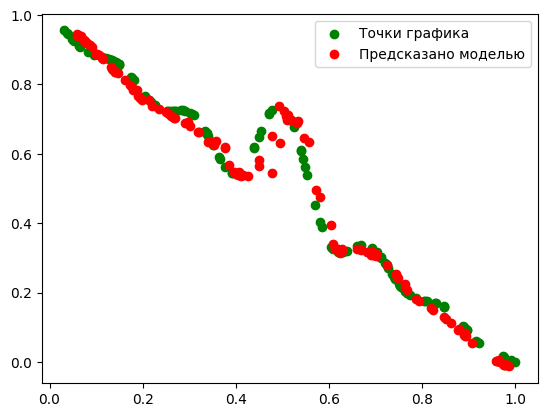

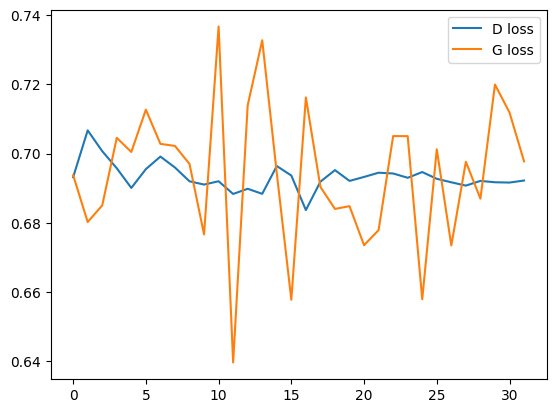

Done


In [7]:
n_epochs = 10  # количество эпох
lr = 0.001  # шаг обучения
b1 = 0.5  # гиперпараметр для оптимайзера Adam
b2 = 0.999  # гиперпараметр для оптимайзера Adam
latent_dim = 100  # Размерность случайного вектора, который подается на вход генератору
sample_interval = 500  # количество итераций для отображения процесса обучения
batch_size = 128

generator = Generator()
discriminator = Discriminator()

# опитимизаторы
optimizer_G = torch.optim.Adam(
    generator.parameters(),
    lr=lr, 
    betas=(b1, b2)
)
optimizer_D = torch.optim.Adam(
    discriminator.parameters(), 
    lr=lr, 
    betas=(b1, b2)
)

# функция ошибки
adversarial_loss = torch.nn.BCELoss()

d_loss_history = []
g_loss_history = []

red_patch = mpatches.Patch(color='red', label='D loss')
green_patch = mpatches.Patch(color='green', label='G loss')


for epoch in range(n_epochs):
    for i, points in enumerate(train_loader):
        
##################### Лейблы для данных: 1 - настоящие, 0 - сгенерированные ########
        valid = torch.FloatTensor(batch_size, 1).fill_(1.0)
        fake = torch.FloatTensor(batch_size, 1).fill_(0.0)

        real_points = points.type(torch.FloatTensor)

        # шум
        z = torch.FloatTensor(np.random.normal(0, 1, (batch_size, latent_dim)))
        # данные на основе шума
        gen_points = generator(z)
        
######################  Тренировка дискриминатора    ##########################
        
        # предсказания дискриминатора на основе реальных данных
        real_pred = discriminator(real_points)
        
        # Тут сравниваем предсказанные значения Дискриминатора(на основе настоящих данных) с настоящими
        d_real_loss = adversarial_loss(real_pred, valid)
        
        # Подаем сгенерированые данные на Дискриминатор 
        fake_pred = discriminator(gen_points)
        
        # ошибка предсказанного
        d_fake_loss = adversarial_loss(fake_pred, fake)
        
        # два лосса в один
        d_loss = (d_real_loss + d_fake_loss) / 2

        optimizer_D.zero_grad()
        d_loss.backward()
        optimizer_D.step()

######################  Тренировка генератора    ##########################
        
        # генерация шума
        z = torch.FloatTensor(np.random.normal(0, 1, (batch_size, latent_dim))) #(B,latent_dim)
        
        # Генерируем данные Генератором на основе шума
        gen_points = generator(z)  #(B,2)

        # Подаем сгенерированые данные на Дискриминатор 
        fake_pred = discriminator(gen_points)  #(B,1)
    
        # Тут сравниваем предсказанные значения Дискриминатора (на основе сгенерировнных данных) с настоящими
        g_loss = adversarial_loss(fake_pred, valid)
        
        # Делаем шаг обучения нашего Генератора
        optimizer_G.zero_grad()
        g_loss.backward()
        optimizer_G.step()

        
        batches_done = epoch * len(train_loader) + i
    
        if batches_done % sample_interval == 0:
            with torch.no_grad():
                
                print(f"[Epoch {epoch}/{n_epochs}] [Batch {i}/{len(train_loader)}] "+\
                      f'[D loss: {round(d_loss.item(), 3)}] [G loss: {round(g_loss.item(), 3)}]') 

                d_loss = d_loss.detach()  # новый тензор без градиента
                g_loss = g_loss.detach()

                d_loss_history.append(d_loss)
                g_loss_history.append(g_loss)

        if epoch==n_epochs-1 and len(train_loader)-1==i:
            print('n_epochs')
            plt.clf()
            plot_points(gen_points, real_points)
            plt.plot(np.array(d_loss_history), label='D loss')
            plt.plot(np.array(g_loss_history), label='G loss')
            plt.legend()
            plt.show()

print('Done')